In [73]:
!pip install ucimlrepo

In [74]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

In [75]:
df = fetch_ucirepo(id=17).data.original

In [76]:
df = fetch_ucirepo(id=17).data.original

encoder = LabelEncoder()
normalizer = StandardScaler()

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

X = normalizer.fit_transform(X)

y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

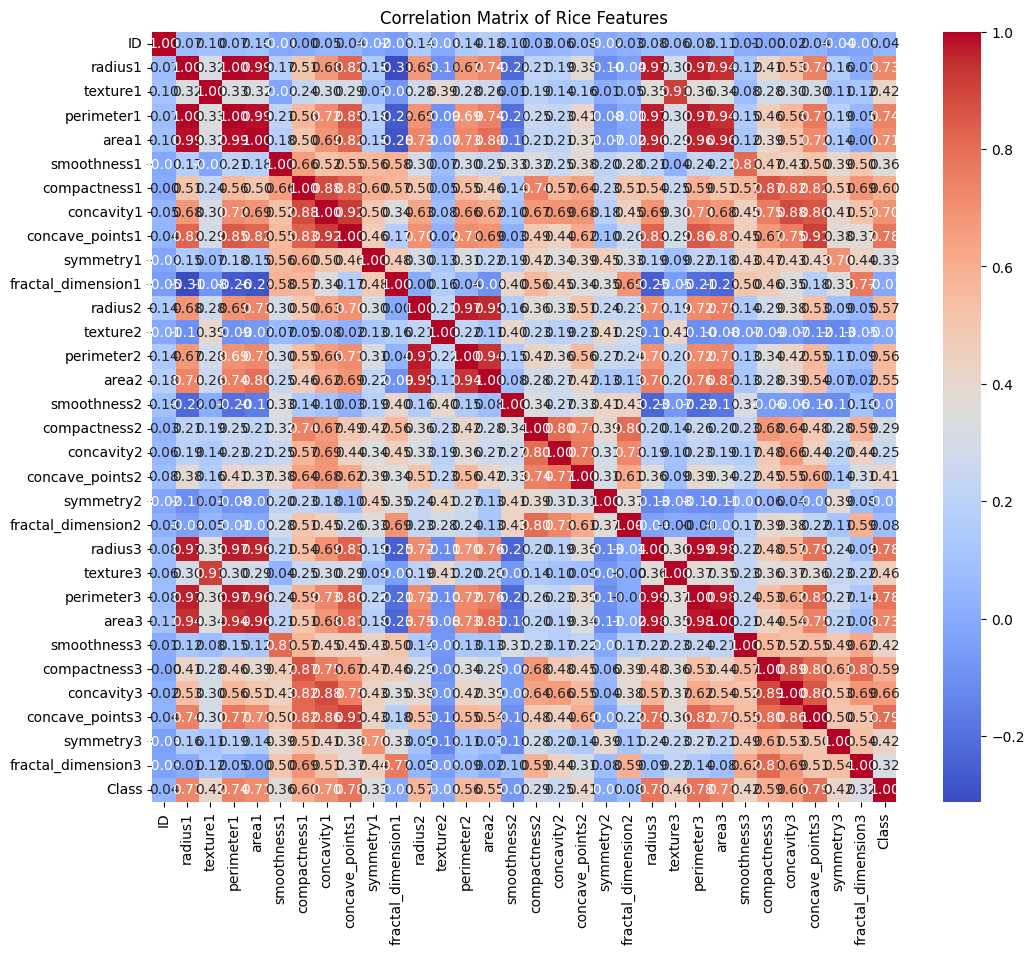

In [77]:
rice_df = pd.DataFrame(X, columns=df.columns[:-1]).copy()
rice_df['Class'] = y

correlation_matrix = rice_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Rice Features')
plt.show()

Isso não me diz nada, só é uma confusão

<ipython-input-78-70398807bd97>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_corr.index, y=class_corr.values, palette='coolwarm')


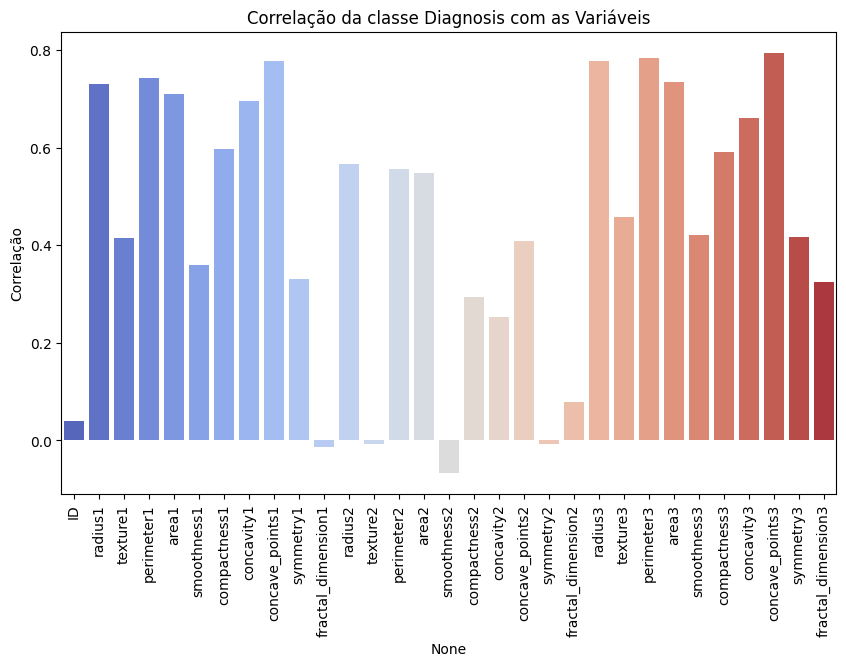

In [78]:
df['Diagnosis'] = y
class_corr = df.corr()['Diagnosis'].drop('Diagnosis')

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=class_corr.index, y=class_corr.values, palette='coolwarm')
plt.title('Correlação da classe Diagnosis com as Variáveis')
plt.ylabel('Correlação')
plt.xticks(rotation=90)
plt.show()

features relevantes:<br>
<br>Alta correlação = ["radius1","perimeter1","area1","radius2","perimeter2","area2","radius3","perimeter3","area3","concavity3","concave_points3"]
<br>
<br> Baixa correlação =<br>
["fractal_dimensional1","texture2","smoothness","symetry2"]

In [79]:
features_strong = ["radius1","perimeter1","area1","radius2","perimeter2","area2","radius3","perimeter3","area3","concavity3","concave_points3"]
features_weak = ["fractal_dimension1","texture2","smoothness2","symmetry2"]

In [80]:
strongcorr = features_strong + ["Diagnosis"]
weakcorr = features_weak + ["Diagnosis"]

df_strong = df[strongcorr]
df_weak = df[weakcorr]

In [81]:
df_strong

#strong variables
X_strong = df_strong.drop(columns=['Diagnosis'])
y_strong = encoder.fit_transform(df_strong['Diagnosis'])

X_strong = normalizer.fit_transform(X_strong)
X_strong_train, X_strong_test, y_strong_train, y_strong_test = train_test_split(X_strong, y_strong, test_size=0.2, random_state=42)

# weak variables
X_weak = df_weak.drop(columns=['Diagnosis'])
y_weak = encoder.fit_transform(df_weak['Diagnosis'])

X_weak = normalizer.fit_transform(X_weak)
X_weak_train, X_weak_test, y_weak_train, y_weak_test = train_test_split(X_weak, y_weak, test_size=0.2, random_state=42)

# Análise: Variaveis fortes

In [82]:
coords = {
    "features": features_strong
}

with pm.Model(coords=coords) as strong_logistic:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta",mu=0,dims="features")

    X = pm.Data("X", X_strong_train)
    y = pm.Data("y", y_strong_train)

    mu = pm.math.dot(X, beta) + alpha

    likelihood = pm.Bernoulli("likelihood", pm.math.invlogit(mu), observed=y)

    #prior
    prior_pred_strong = pm.sample_prior_predictive()

Análise prior

<Axes: ylabel='Count'>

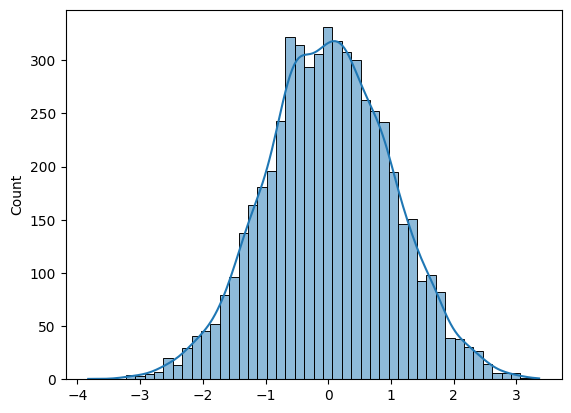

In [83]:
sns.histplot(prior_pred_strong.prior["beta"].values.flatten(),kde=True)

<Axes: ylabel='Count'>

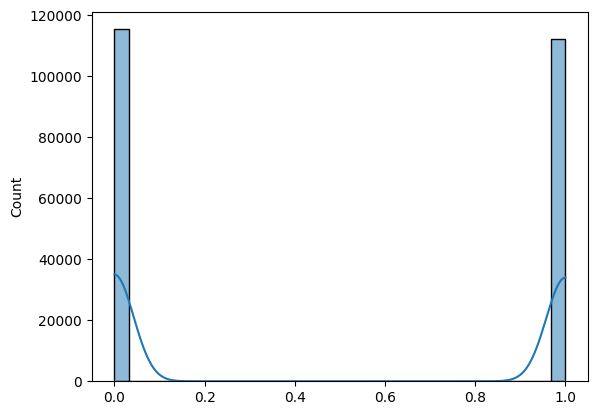

In [84]:
sns.histplot(prior_pred_strong.prior_predictive["likelihood"].values.flatten(),kde=True)

show

In [85]:
with strong_logistic:
    trace_strong = pm.sample(1000)

Output()

Output()

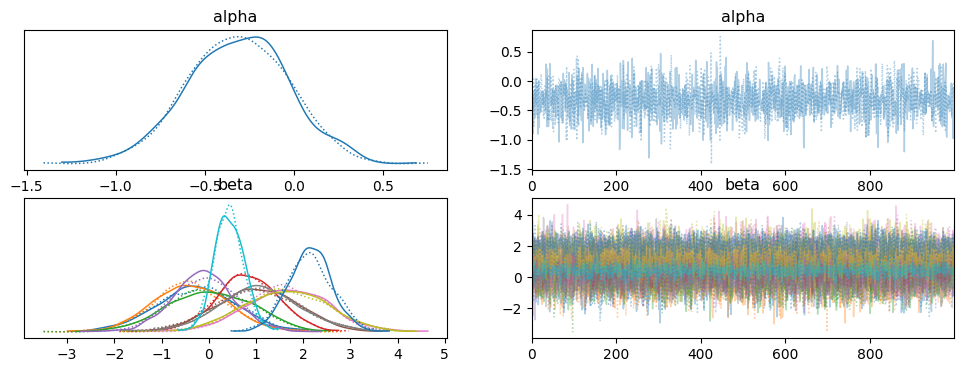

In [86]:
az.plot_trace(trace_strong, var_names=["alpha", "beta"])
plt.show()

Parece bom

In [87]:
print(pm.summary(trace_strong))

                        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                 -0.315  0.285  -0.818    0.256      0.006    0.005   
beta[radius1]         -0.252  0.842  -1.845    1.285      0.017    0.018   
beta[perimeter1]      -0.386  0.802  -1.908    1.114      0.016    0.017   
beta[area1]            0.032  0.885  -1.644    1.618      0.019    0.020   
beta[radius2]          0.810  0.663  -0.368    2.117      0.014    0.012   
beta[perimeter2]      -0.114  0.670  -1.437    1.046      0.013    0.017   
beta[area2]            1.021  0.874  -0.678    2.601      0.017    0.015   
beta[radius3]          1.642  0.851   0.101    3.260      0.016    0.012   
beta[perimeter3]       1.078  0.862  -0.485    2.822      0.016    0.015   
beta[area3]            1.621  0.894  -0.052    3.287      0.015    0.013   
beta[concavity3]       0.425  0.318  -0.175    0.995      0.007    0.005   
beta[concave_points3]  2.135  0.477   1.222    3.018      0.010    0.007   

           

Promissor!

In [88]:
with strong_logistic:
    pm.set_data({"X":X_strong_test,"y":y_strong_test})
    posterior_pred_strong = pm.sample_posterior_predictive(trace_strong)

Output()

<Axes: xlabel='likelihood'>

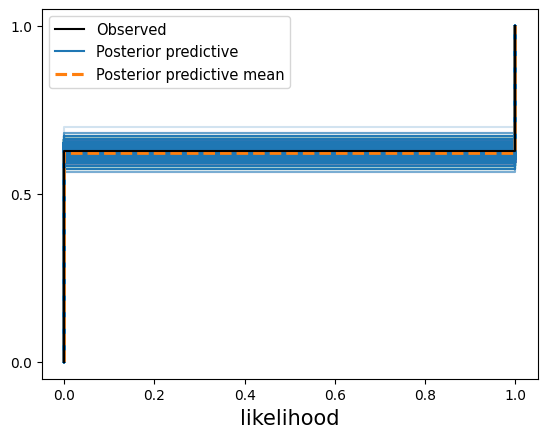

In [89]:
az.plot_ppc(posterior_pred_strong,group="posterior",kind="cumulative")

Não parece muito bom, ele varia muito no centro

In [90]:
mean_likelihood_strong = posterior_pred_strong.posterior_predictive["likelihood"].mean(dim=["chain", "draw"])
binary_predictions_strong = (mean_likelihood_strong > 0.5).astype(int)

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_strong_test, binary_predictions_strong)

recall = recall_score(y_strong_test, binary_predictions_strong)

f1 = f1_score(y_strong_test, binary_predictions_strong)

print("Strong metrics: \n")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy_score(y_strong_test, binary_predictions_strong):.4f}")

Strong metrics: 

Precision: 1.0000
Recall: 0.9535
F1 Score: 0.9762
Accuracy: 0.9825


Ok ele foi bem!

# Análise Variaveis fracas

In [92]:
coords = {
    "features": features_weak
}

with pm.Model(coords=coords) as weak_logistic:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta",mu=0,dims="features")

    X = pm.Data("X", X_weak_train)
    y = pm.Data("y", y_weak_train)

    mu = pm.math.dot(X, beta) + alpha
    likelihood = pm.Bernoulli("likelihood", pm.math.invlogit(mu), observed=y)

    #prior
    prior_pred_weak = pm.sample_prior_predictive()

<Axes: ylabel='Count'>

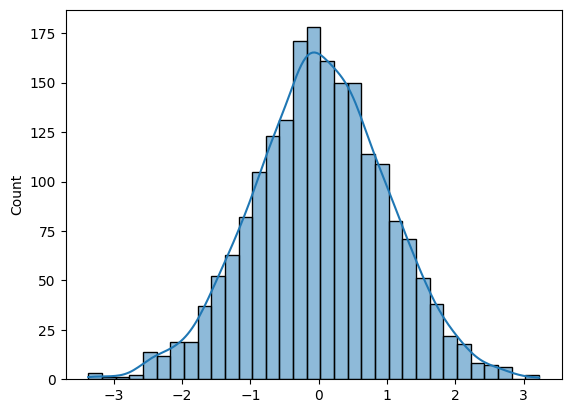

In [93]:
sns.histplot(prior_pred_weak.prior["beta"].values.flatten(),kde=True)

<Axes: ylabel='Count'>

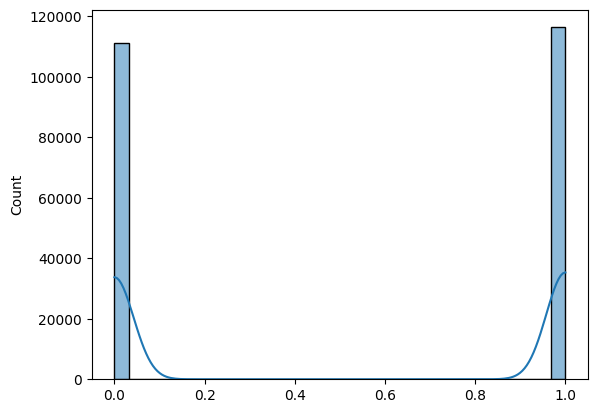

In [94]:
sns.histplot(prior_pred_weak.prior_predictive["likelihood"].values.flatten(),kde=True)

In [95]:
with weak_logistic:
    trace_weak = pm.sample(1000)

Output()

Output()

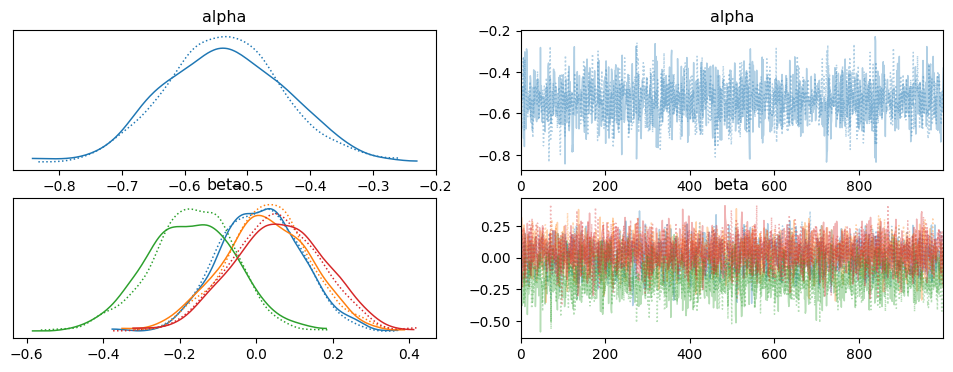

In [96]:
az.plot_trace(trace_weak, var_names=["alpha", "beta"])
plt.show()

Talvez tenha convergido melhor?

In [97]:
print(pm.summary(trace_weak))

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                    -0.536  0.097  -0.719   -0.355      0.002    0.002   
beta[fractal_dimension1]  0.010  0.106  -0.191    0.196      0.002    0.002   
beta[texture2]            0.026  0.114  -0.194    0.235      0.003    0.002   
beta[smoothness2]        -0.169  0.114  -0.393    0.037      0.003    0.002   
beta[symmetry2]           0.054  0.120  -0.161    0.277      0.003    0.002   

                          ess_bulk  ess_tail  r_hat  
alpha                       1970.0    1280.0   1.00  
beta[fractal_dimension1]    2249.0    1693.0   1.00  
beta[texture2]              1618.0    1469.0   1.00  
beta[smoothness2]           1996.0    1780.0   1.01  
beta[symmetry2]             1614.0    1630.0   1.00  


In [98]:
with weak_logistic:
    pm.set_data({"X":X_weak_test,"y":y_weak_test})
    posterior_pred_weak = pm.sample_posterior_predictive(trace_weak)

Output()

<Axes: xlabel='likelihood'>

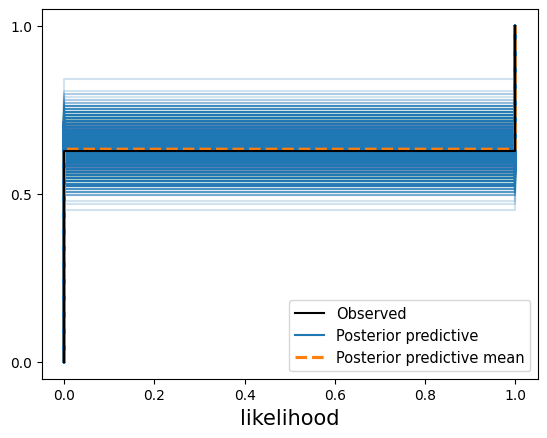

In [99]:
az.plot_ppc(posterior_pred_weak,group="posterior",kind="cumulative")

Talvez não tenha convergido tanto assim

In [100]:
mean_likelihood_weak = posterior_pred_weak.posterior_predictive["likelihood"].mean(dim=["chain", "draw"])
binary_predictions_weak = (mean_likelihood_weak > 0.5).astype(int)

In [101]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_weak_test, binary_predictions_weak)

recall = recall_score(y_weak_test, binary_predictions_weak)

f1 = f1_score(y_weak_test, binary_predictions_weak)

print("Strong metrics: \n")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy_score(y_weak_test, binary_predictions_weak):.4f}")

Strong metrics: 

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6228


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Não foi bom

#Conclusão <br>
O modelo que contém váriaveis com maior correlação com o target se saiu melhor do que o modelo que continham váriaveis fracas.